In [1]:
from IPython.display import clear_output

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

clear_output()

In [3]:
import os
import re

import random

from operator import itemgetter, attrgetter
from itertools import islice, product
from collections import defaultdict

import numpy as np
import pandas as pd

from tqdm import tqdm

In [4]:
if not os.path.isdir('idao_dataset'):
    !pip install wldhx.yadisk-direct -qqq
    !curl -L $(yadisk-direct https://yadi.sk/d/UJ8DEma9LHRMsg) -o track_1.tar
    !tar xvf track_1.tar
    !rm track_1.tar

    # download from https://disk.yandex.ru/d/IC_vZbCcsEt03g
    !wget "https://s273vla.storage.yandex.net/rdisk/a427be40f9544defcb84e1950423bd2deef05a8d6a8528003329d93c174be44c/606508ee/bgrUSZap4U7F2FfQ-AWWcVCFnOObN1NGdFdocrjauwwvrixOJyYxAoSxQKitKzeuFt9xHujJSr2uP71e7TVa8Q==?uid=0&filename=track_1_private_test_final_27_03.zip&disposition=attachment&hash=OGTrMEeD15wCqdRSSwqp1R7gwsF1YKDyVMBb9IvYl2THpFxspvPSVhI6UMio3CQsq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/track_1_private_test_final_27_03.zip&limit=0&content_type=application%2Fzip&owner_uid=44214498&fsize=2712019001&hid=3fb11601607208c5cf34a9916e16636d&media_type=compressed&tknv=v2&rtoken=1Ek0dI79VFJF&force_default=no&ycrid=na-ebac668a11ca5b87dea2b49544bd67c4-downloader22e&ts=5beddab819780&s=d93a735698a67627e63423fa368d6d46fdf77fe29d4357c242e3b24ac9c59e39&pb=U2FsdGVkX18YJsJVkN2vng8Dd7tmcQYsCZLgegKPIar8P_7gOYbzpOCw-yoJQSvVCcUMfrfILrUvH3eA6laVGOkgvdFx0_KEZVrXzEcH2Pk" -O track_1_private_new.zip
    !unzip track_1_private_new.zip
    !rm -r __MACOSX
    !mv private_test idao_dataset/private_test_new
    !rm track_1_private_new.zip

clear_output()

In [5]:
DATA_DIR = "./idao_dataset/"
WORK_DIR = "/content/drive/My Drive/idao-2021"

In [27]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
import cv2

import albumentations as A

from skimage.measure import regionprops, label as regionlabel

from torch.utils.data.dataset import IterableDataset, Dataset

from PIL import Image
from multiprocessing import Pool, cpu_count

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold


NUM_THREADS = cpu_count()

MAPPING_CLASS_INV = ['He_NR', 'ER']
MAPPING_CLASS = {v: k for k, v in enumerate(MAPPING_CLASS_INV)}

MAPPING_VALUE_INV = [1, 3, 6, 10, 20, 30]
MAPPING_VALUE = {v: k for k, v in enumerate(product([0, 1], MAPPING_VALUE_INV))}
MAPPING_VALUE_INV = np.tile(MAPPING_VALUE_INV, 2)

IMG_SIZE_ORIGIN = 576
IMG_SIZE_ORIGIN_DIV_2 = IMG_SIZE_ORIGIN // 2

IMG_SIZE_SELECT = 120
IMG_SIZE_SELECT_DIV_2 = IMG_SIZE_SELECT // 2

kernel_5 = np.ones((5, 5), np.uint8)


def create_mask(img, thrsh=100, border=10):
    # mask = cv2.medianBlur(img, 3)
    mask = (img > thrsh).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_5)
    mask = cv2.dilate(mask, kernel_5, iterations=1)
    
    mask[:border, :] = mask[-border:, :] = 0
    mask[:, :border] = mask[:, -border:] = 0
    
    return mask


def fix_bbox(img_shape, bbox):
    y_min, x_min, y_max, x_max = bbox

    h_box, w_box = y_max - y_min, x_max - x_min
    h_max, w_max = img_shape

    assert h_box <= h_max and w_box <= w_max

    if y_min < 0:
        y_min, y_max = 0, h_box
    elif y_max > h_max:
        y_min, y_max = h_max - h_box, h_max

    if x_min < 0:
        x_min, x_max = 0, w_box
    elif x_max > w_max:
        x_min, x_max = w_max - w_box, w_max

    return y_min, x_min, y_max, x_max


def find_object_bbox(img, area_thrsh=150):
    img_mask = create_mask(img)
    img_mask = regionlabel(img_mask)
    
    props = regionprops(img_mask)
    props = max(props, key=attrgetter('area'), default=None)

    if props is not None:
        centroid_y, centroid_x = map(int, props.centroid)
    else:
        centroid_y, centroid_x = IMG_SIZE_ORIGIN_DIV_2, IMG_SIZE_ORIGIN_DIV_2

    y_min, x_min, y_max, x_max = (
        centroid_y - IMG_SIZE_SELECT_DIV_2,
        centroid_x - IMG_SIZE_SELECT_DIV_2,
        centroid_y + IMG_SIZE_SELECT_DIV_2,
        centroid_x + IMG_SIZE_SELECT_DIV_2,
    )

    bbox = x_min, y_min, x_max, y_max
    bbox = fix_bbox(img.shape, bbox)
    return bbox


def process_image(img_path):
    img_name = os.path.basename(img_path)
    img_name_re = re.search('__CYGNO_\d+_\d+_(\w*)_(\d+)_keV', img_name)
    if img_name_re:
        img_class = MAPPING_CLASS[img_name_re.group(1)]
        img_value = int(img_name_re.group(2))
        img_value = MAPPING_VALUE[(img_class, img_value)]
    else:
        img_class, img_value = None, None

    img = np.asarray(Image.open(img_path))
    x_min, y_min, x_max, y_max = find_object_bbox(img)
    img = img[y_min:y_max, x_min:x_max]
    img = cv2.medianBlur(img, ksize=3)

    return img, img_class, img_value, img_name


class IDAODataset(Dataset):
    def __init__(self, images, labels, values, filenames, batch_size=128,
                 transform=None, apply_transform_optional=True, random_state=None):
        super(IDAODataset, self).__init__()

        self.images = images
        self.labels = labels
        self.values = values

        self.filenames = filenames
        
        self.random_state = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.images))
        self.batch_size = batch_size

        self.transform = transform
        self.transform_fn = self.create_transform_fn(transform, apply_transform_optional)

    def create_transform_fn(self, transform, apply_transform_optional):
        if transform is None:
            return None

        transform = [tr for tr, is_required in transform
                     if is_required or apply_transform_optional]
        
        if not transform:
            return None

        return A.Compose(transform)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx

        if not (0 <= idx < len(self)):
            raise IndexError(idx)

        offset_beg, offset_end = idx * self.batch_size, (idx + 1) * self.batch_size
        item_slice = self.indices[offset_beg:offset_end]

        images = self.images[item_slice]

        if self.transform_fn is not None:
            images = [self.transform_fn(image=image)["image"] for image in images]

        images = np.asarray(images)
        images = torch.tensor(images, dtype=torch.float, device=device).unsqueeze(1)

        if self.labels is not None and self.values is not None:
            labels = self.labels[item_slice]
            values = self.values[item_slice]

            values = torch.tensor(values, dtype=torch.long, device=device)
            labels = torch.tensor(labels, dtype=torch.float, device=device).unsqueeze(1)
        else:
            labels, values = None, None

        return (images, labels, values)

    def __len__(self):
        return int(np.ceil(self.indices.shape[0] / self.batch_size))

    def shuffle(self):
        self.random_state.shuffle(self.indices)

    def set_random_state(self, random_state=None):
        self.random_state = np.random.RandomState(random_state)

    @classmethod
    def from_path(cls, path, batch_size=128, transform=None, apply_transform_optional=True,
                  has_target=True, random_state=None):
        with Pool(processes=NUM_THREADS) as pool:
            images_paths = Path(path).rglob('*.png')
            images_paths = sorted(map(str, images_paths))
            images = pool.imap(process_image, tqdm(images_paths, position=0), chunksize=10)
            images = list(images)

        return cls(
            images=np.asarray([img for img, _, _, _ in images]),
            labels=np.asarray([cls for _, cls, _, _ in images]) if has_target else None,
            values=np.asarray([val for _, _, val, _ in images]) if has_target else None,
            filenames=np.asarray([name for _, _, _, name in images]),
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )

    def _train_test_split(self, indices_train, indices_test):
        cls = type(self)
        
        dataset_train = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=True,
            batch_size=self.batch_size,
        )

        dataset_test = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=False,
            batch_size=self.batch_size,
        )

        # ad hoc for no copy in fancy indexing
        dataset_train.indices = self.indices[indices_train]
        dataset_test.indices  = self.indices[indices_test]

        return dataset_train, dataset_test

    def split(self, test_size=0.3, random_state=None):
        indices_train, indices_test = train_test_split(
            self.indices, test_size=test_size, random_state=random_state)
        return self._train_test_split(indices_train, indices_test)

    def cv_split(self, n_splits=5, shuffle=True, stratified=True, random_state=None):
        if stratified:
            # strata_labels = self.labels[self.indices]
            strata_values = self.values[self.indices]
            strata = strata_values

            print(repr(np.bincount(strata).reshape(-1, 2)))

            kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
            splits = kf.split(self.indices, strata)
        else:
            kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
            splits = kf.split(self.indices)

        for indices_train, indices_test in splits:
            yield self._train_test_split(indices_train, indices_test)

In [29]:
# sorted by file construction

examples_extra = pd.read_csv(os.path.join(WORK_DIR, 'examples_extra.csv'), index_col=['id'])
examples_extra.index = examples_extra.index + '.png'
examples_extra.head()

,cluster,label,value
id,,,
0002894871bb30af2670648c58b2506e9801a321.png,6,1,20
000a95ca23df016a149ff9af94b6e9d8633d6691.png,10,0,30
000c45d729066044e3dd3f885fddf013b845b6d7.png,6,1,20
0011f80e44faa713714ead6aeab3b2f9db54aebd.png,8,0,10
0019c489db95ca9ee6e558274700ef3d76d37532.png,10,0,30


In [30]:
examples_extra_values = examples_extra['value'].to_dict()
examples_extra_labels = examples_extra['label'].to_dict()

In [31]:
%%time

random.seed(68)

try:
    dataset = IDAODataset(
        images=dataset.images,
        labels=dataset.labels,
        values=dataset.values,
        filenames=dataset.filenames,
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )
except NameError as e:
    print(e)

    dataset = IDAODataset.from_path(
        path='idao_dataset/train/',
        transform=[
            (A.Flip(p=0.25), False),
            (A.RandomRotate90(p=0.25), False),
        ],
        apply_transform_optional=True,
        has_target=True,
    )

    dataset_test_old = IDAODataset.from_path(
        path='idao_dataset/private_test/',
        transform=dataset.transform,
        apply_transform_optional=True,
        has_target=False,
    )

    dataset_test_new = IDAODataset.from_path(
        path='idao_dataset/private_test_new/',
        transform=dataset.transform,
        apply_transform_optional=True,
        has_target=False,
    )

    dataset_test = IDAODataset(
        images=np.vstack([dataset_test_old.images, dataset_test_new.images]),
        labels=None,
        values=None,
        filenames=np.hstack([dataset_test_old.filenames, dataset_test_new.filenames]),
        transform=dataset.transform,
        apply_transform_optional=True,
    )

    del dataset_test_old, dataset_test_new

    mask = np.isin(dataset_test.filenames, examples_extra.index.values, assume_unique=True)
    filenames = dataset_test.filenames[mask]

    dataset_test = IDAODataset(
        images=dataset_test.images[mask],
        labels=np.asarray([examples_extra_labels[f] for f in filenames]),
        values=np.asarray([MAPPING_VALUE[(examples_extra_labels[f], examples_extra_values[f])] for f in filenames]),
        filenames=filenames,
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )

    dataset = IDAODataset(
        images=np.vstack([dataset.images, dataset_test.images]),
        labels=np.hstack([dataset.labels, dataset_test.labels]),
        values=np.hstack([dataset.values, dataset_test.values]),
        filenames=np.hstack([dataset.filenames, dataset_test.filenames]),
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )

    del dataset_test

dataset_folds = list(dataset.cv_split(random_state=42))

for train, valid in dataset_folds:
    train.set_random_state(9872)
    valid.set_random_state(9872)

len(dataset_folds)

array([[2177,  802],
       [2255, 4002],
       [2208, 4002],
       [ 803, 2243],
       [4001, 2272],
       [4002, 2237]])
CPU times: user 14.9 ms, sys: 666 µs, total: 15.6 ms
Wall time: 18.2 ms


In [32]:
dataset.images.shape

(31004, 120, 120)

In [33]:
dataset.labels.max()

1

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class IDAONet(nn.Module):
    def __init__(self):
        super(IDAONet, self).__init__()

        self._conv = nn.Sequential(
            nn.BatchNorm2d(1),

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3),

            nn.Flatten(),
            nn.ReLU(),
        )

        self._cls_labels = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 1),
        )

        self._cls_values = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, len(MAPPING_VALUE_INV)),
        )

    def forward(self, images):
        images = self._conv(images)
        labels = self._cls_labels(images)
        values = self._cls_values(images)
        return labels, values

In [35]:
net = IDAONet().to(device)
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [42]:
def train_func(model: nn.Module, iterator, criteria, optimizer, verbose=True):
    epoch_loss = 0
    num_samples = 0
    
    criterion_labels, criterion_values = criteria

    iterator.shuffle()
    model.train()
    
    if verbose:
        iterator = tqdm(iterator, position=0, desc='batches')

    for images, labels_true, values_true in iterator:
        optimizer.zero_grad()

        labels_pred, values_pred = model(images)

        loss = criterion_labels(labels_pred, labels_true) + \
               criterion_values(values_pred, values_true)
        loss.backward()

        epoch_loss += loss.item()
        num_samples += images.shape[0]

        optimizer.step()

    return epoch_loss / num_samples, np.nan

In [37]:
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.metrics import roc_curve


def evaluate_func(model: nn.Module, iterator, verbose=True, return_misclassified=False):
    epoch_loss = 0
    num_samples = 0

    model.eval()

    if verbose:
        iterator_ = tqdm(iterator, position=0, desc='batches')
    else:
        iterator_ = iterator

    labels_pred_all, values_pred_all = [], []

    with torch.no_grad():
        for images, labels_true, values_true in iterator_:
            labels_pred, values_pred = model(images)
            labels_pred = torch.sigmoid(labels_pred)

            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)

    labels_true = iterator.labels[iterator.indices]
    values_true = iterator.values[iterator.indices]

    values_pred = MAPPING_VALUE_INV[values_pred]
    values_true = MAPPING_VALUE_INV[values_true]

    score_auc = roc_auc_score(labels_true, labels_pred)
    score_mae = mean_absolute_error(values_true, values_pred)

    metrics = {'auc': score_auc, 'mae': score_mae}
    score = score_auc - score_mae

    if return_misclassified:
        fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
        threshold_best = thresholds[np.argmax(tpr - fpr)]

        errors = ((labels_true - (labels_pred > threshold_best)) != 0).astype(int) * 1 + \
                 ((values_true - values_pred) != 0).astype(int) * 2
        mask = errors > 0
        return iterator.filenames[iterator.indices[mask]], errors[mask]

    return np.nan, score, metrics

In [38]:
import torch.optim as optim

criteria = [
    torch.nn.BCEWithLogitsLoss(reduction='sum'),
    torch.nn.CrossEntropyLoss(reduction='sum'),
]

optimizer = optim.Adam(lr=0.001, params=net.parameters())
_ = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)

In [39]:
def update_lr(optimizer, gamma):
    for params in optimizer.param_groups:
        params['lr'] *= gamma

In [40]:
CHECKPOINTS = os.path.join(WORK_DIR, "checkpoints_2.track1")

!rm -r "{CHECKPOINTS}" || true
!mkdir -p "{CHECKPOINTS}"
!ls -l "{CHECKPOINTS}"

total 0


In [41]:
class EarlyStopping:
    def __init__(self, max_attempt=5):
        self.attempt = -1
        self.max_attempt = max_attempt
        
        self.best_score = -1
        self.best_attempt = -1

    def add_score(self, score):
        self.attempt += 1

        if self.best_score < score:
            self.best_score = score
            self.best_attempt = self.attempt

    def is_valid(self):
        return (self.attempt - self.best_attempt) <= self.max_attempt

In [43]:
NUM_EPOCHS = 70
NUM_ATTEMPTS = 10


es = EarlyStopping(max_attempt=NUM_ATTEMPTS)


def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()


params = {
    'criteria': criteria,
    'optimizer': optimizer,
    'verbose': False,
}


STR_OFFSET = ' ' * 11


for epoch in range(NUM_EPOCHS):
    scores = defaultdict(list)

    model_path = os.path.join(CHECKPOINTS, f'epoch_{epoch+1}')
    !mkdir -p "{model_path}"

    for fold, (train, valid) in enumerate(tqdm(dataset_folds), 1):
        model_prev = os.path.join(CHECKPOINTS, f'epoch_{epoch}', f'model_fold_{fold}.model')
        model_next = os.path.join(CHECKPOINTS, f'epoch_{epoch+1}', f'model_fold_{fold}.model')

        is_trained = os.path.isfile(model_next)

        if not is_trained:
            if epoch > 0:
                net.load_state_dict(torch.load(model_prev))
            else:
                net.apply(weight_reset)

            train_loss, train_score = train_func(net, train, **params)
            torch.save(net.state_dict(), model_next)
        else:
            net.load_state_dict(torch.load(model_next))
            train_loss, train_score = np.nan, np.nan

        valid_loss, valid_score, valid_metrics = evaluate_func(net, valid, verbose=False)
        
        scores['train_loss'].append(train_loss)
        scores['valid_loss'].append(valid_loss)

        scores['train_score'].append(train_score)
        scores['valid_score'].append(valid_score)

        for k, v in valid_metrics.items():
            scores['valid_' + k].append(v)

    train_loss, train_score = np.mean(scores['train_loss']), np.mean(scores['train_score'])
    valid_loss, valid_score = np.mean(scores['valid_loss']), np.mean(scores['valid_score'])
    
    valid_auc, valid_mae = np.mean(scores['valid_auc']), np.mean(scores['valid_mae'])

    print()
    print(f"Epoch = {epoch+1:02d}; "
          f"Train Loss: {train_loss:.6f}; Train Score: {train_score:.6f}; "
          f"Val. Loss: {valid_loss:.6f}; Val. Score: {valid_score:.6f}")
    print(STR_OFFSET, f"Val. AUC: {valid_auc:.6f}; Val. MAE: {valid_mae:.6f}")

    if (epoch + 1) % 5 == 0:
        update_lr(optimizer, 0.75)

    es.add_score(valid_score)
    if not es.is_valid():
        break

    epoch_remove = epoch - (NUM_ATTEMPTS + 1)
    if epoch_remove >= 0:
        model_path = os.path.join(CHECKPOINTS, f'epoch_{epoch_remove+1}')
        !rm -r "{model_path}"

100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


Epoch = 01; Train Loss: 1.305582; Train Score: nan; Val. Loss: nan; Val. Score: 0.769175
            Val. AUC: 0.993273; Val. MAE: 0.224098



100%|██████████| 5/5 [00:53<00:00, 10.72s/it]


Epoch = 02; Train Loss: 0.414130; Train Score: nan; Val. Loss: nan; Val. Score: 0.767386
            Val. AUC: 0.997615; Val. MAE: 0.230229



100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


Epoch = 03; Train Loss: 0.296804; Train Score: nan; Val. Loss: nan; Val. Score: 0.885313
            Val. AUC: 0.999267; Val. MAE: 0.113954



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 04; Train Loss: 0.251688; Train Score: nan; Val. Loss: nan; Val. Score: 0.903820
            Val. AUC: 0.999583; Val. MAE: 0.095764



100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


Epoch = 05; Train Loss: 0.219616; Train Score: nan; Val. Loss: nan; Val. Score: 0.891920
            Val. AUC: 0.999455; Val. MAE: 0.107534



100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


Epoch = 06; Train Loss: 0.175204; Train Score: nan; Val. Loss: nan; Val. Score: 0.928131
            Val. AUC: 0.999735; Val. MAE: 0.071604



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 07; Train Loss: 0.169710; Train Score: nan; Val. Loss: nan; Val. Score: 0.932486
            Val. AUC: 0.999799; Val. MAE: 0.067313



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 08; Train Loss: 0.158057; Train Score: nan; Val. Loss: nan; Val. Score: 0.932260
            Val. AUC: 0.999832; Val. MAE: 0.067571



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 09; Train Loss: 0.152572; Train Score: nan; Val. Loss: nan; Val. Score: 0.952960
            Val. AUC: 0.999793; Val. MAE: 0.046833



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 10; Train Loss: 0.137609; Train Score: nan; Val. Loss: nan; Val. Score: 0.928670
            Val. AUC: 0.999789; Val. MAE: 0.071119



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 11; Train Loss: 0.120321; Train Score: nan; Val. Loss: nan; Val. Score: 0.952342
            Val. AUC: 0.999917; Val. MAE: 0.047574



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 12; Train Loss: 0.113800; Train Score: nan; Val. Loss: nan; Val. Score: 0.955785
            Val. AUC: 0.999876; Val. MAE: 0.044091



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 13; Train Loss: 0.114234; Train Score: nan; Val. Loss: nan; Val. Score: 0.953753
            Val. AUC: 0.999908; Val. MAE: 0.046155



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 14; Train Loss: 0.109383; Train Score: nan; Val. Loss: nan; Val. Score: 0.954001
            Val. AUC: 0.999930; Val. MAE: 0.045930



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 15; Train Loss: 0.110871; Train Score: nan; Val. Loss: nan; Val. Score: 0.935404
            Val. AUC: 0.999879; Val. MAE: 0.064476



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 16; Train Loss: 0.093909; Train Score: nan; Val. Loss: nan; Val. Score: 0.961832
            Val. AUC: 0.999891; Val. MAE: 0.038060



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 17; Train Loss: 0.088914; Train Score: nan; Val. Loss: nan; Val. Score: 0.955423
            Val. AUC: 0.999933; Val. MAE: 0.044510



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 18; Train Loss: 0.090494; Train Score: nan; Val. Loss: nan; Val. Score: 0.953797
            Val. AUC: 0.999952; Val. MAE: 0.046155



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 19; Train Loss: 0.087326; Train Score: nan; Val. Loss: nan; Val. Score: 0.952347
            Val. AUC: 0.999954; Val. MAE: 0.047607



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 20; Train Loss: 0.090141; Train Score: nan; Val. Loss: nan; Val. Score: 0.957487
            Val. AUC: 0.999933; Val. MAE: 0.042446



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 21; Train Loss: 0.078133; Train Score: nan; Val. Loss: nan; Val. Score: 0.962309
            Val. AUC: 0.999853; Val. MAE: 0.037544



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 22; Train Loss: 0.075001; Train Score: nan; Val. Loss: nan; Val. Score: 0.963054
            Val. AUC: 0.999953; Val. MAE: 0.036898



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 23; Train Loss: 0.075109; Train Score: nan; Val. Loss: nan; Val. Score: 0.961012
            Val. AUC: 0.999942; Val. MAE: 0.038930



100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Epoch = 24; Train Loss: 0.073485; Train Score: nan; Val. Loss: nan; Val. Score: 0.963493
            Val. AUC: 0.999940; Val. MAE: 0.036447



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 25; Train Loss: 0.074755; Train Score: nan; Val. Loss: nan; Val. Score: 0.964519
            Val. AUC: 0.999966; Val. MAE: 0.035447



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 26; Train Loss: 0.065124; Train Score: nan; Val. Loss: nan; Val. Score: 0.968175
            Val. AUC: 0.999945; Val. MAE: 0.031770



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 27; Train Loss: 0.065298; Train Score: nan; Val. Loss: nan; Val. Score: 0.967502
            Val. AUC: 0.999917; Val. MAE: 0.032415



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 28; Train Loss: 0.064437; Train Score: nan; Val. Loss: nan; Val. Score: 0.958717
            Val. AUC: 0.999937; Val. MAE: 0.041220



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 29; Train Loss: 0.064111; Train Score: nan; Val. Loss: nan; Val. Score: 0.964765
            Val. AUC: 0.999954; Val. MAE: 0.035189



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 30; Train Loss: 0.063878; Train Score: nan; Val. Loss: nan; Val. Score: 0.962157
            Val. AUC: 0.999927; Val. MAE: 0.037769



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 31; Train Loss: 0.057046; Train Score: nan; Val. Loss: nan; Val. Score: 0.970664
            Val. AUC: 0.999950; Val. MAE: 0.029286



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 32; Train Loss: 0.058549; Train Score: nan; Val. Loss: nan; Val. Score: 0.965925
            Val. AUC: 0.999953; Val. MAE: 0.034028



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 33; Train Loss: 0.056379; Train Score: nan; Val. Loss: nan; Val. Score: 0.963514
            Val. AUC: 0.999961; Val. MAE: 0.036447



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 34; Train Loss: 0.055801; Train Score: nan; Val. Loss: nan; Val. Score: 0.970188
            Val. AUC: 0.999959; Val. MAE: 0.029770



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 35; Train Loss: 0.056401; Train Score: nan; Val. Loss: nan; Val. Score: 0.967392
            Val. AUC: 0.999968; Val. MAE: 0.032576



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 36; Train Loss: 0.052579; Train Score: nan; Val. Loss: nan; Val. Score: 0.970149
            Val. AUC: 0.999984; Val. MAE: 0.029835



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 37; Train Loss: 0.052349; Train Score: nan; Val. Loss: nan; Val. Score: 0.970257
            Val. AUC: 0.999963; Val. MAE: 0.029706



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 38; Train Loss: 0.052132; Train Score: nan; Val. Loss: nan; Val. Score: 0.968934
            Val. AUC: 0.999962; Val. MAE: 0.031028



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 39; Train Loss: 0.051799; Train Score: nan; Val. Loss: nan; Val. Score: 0.970142
            Val. AUC: 0.999977; Val. MAE: 0.029835



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 40; Train Loss: 0.051007; Train Score: nan; Val. Loss: nan; Val. Score: 0.970834
            Val. AUC: 0.999959; Val. MAE: 0.029125



100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Epoch = 41; Train Loss: 0.047914; Train Score: nan; Val. Loss: nan; Val. Score: 0.970684
            Val. AUC: 0.999971; Val. MAE: 0.029286



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 42; Train Loss: 0.049182; Train Score: nan; Val. Loss: nan; Val. Score: 0.970155
            Val. AUC: 0.999957; Val. MAE: 0.029803



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 43; Train Loss: 0.047478; Train Score: nan; Val. Loss: nan; Val. Score: 0.972000
            Val. AUC: 0.999965; Val. MAE: 0.027964



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 44; Train Loss: 0.048478; Train Score: nan; Val. Loss: nan; Val. Score: 0.972634
            Val. AUC: 0.999953; Val. MAE: 0.027319



100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


Epoch = 45; Train Loss: 0.047101; Train Score: nan; Val. Loss: nan; Val. Score: 0.972077
            Val. AUC: 0.999976; Val. MAE: 0.027900



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 46; Train Loss: 0.044668; Train Score: nan; Val. Loss: nan; Val. Score: 0.973073
            Val. AUC: 0.999973; Val. MAE: 0.026900



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 47; Train Loss: 0.045781; Train Score: nan; Val. Loss: nan; Val. Score: 0.972907
            Val. AUC: 0.999968; Val. MAE: 0.027061



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 48; Train Loss: 0.045528; Train Score: nan; Val. Loss: nan; Val. Score: 0.972854
            Val. AUC: 0.999980; Val. MAE: 0.027125



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 49; Train Loss: 0.044368; Train Score: nan; Val. Loss: nan; Val. Score: 0.972584
            Val. AUC: 0.999968; Val. MAE: 0.027384



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 50; Train Loss: 0.045931; Train Score: nan; Val. Loss: nan; Val. Score: 0.974619
            Val. AUC: 0.999971; Val. MAE: 0.025352



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 51; Train Loss: 0.043607; Train Score: nan; Val. Loss: nan; Val. Score: 0.972427
            Val. AUC: 0.999972; Val. MAE: 0.027545



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 52; Train Loss: 0.043602; Train Score: nan; Val. Loss: nan; Val. Score: 0.971559
            Val. AUC: 0.999975; Val. MAE: 0.028415



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 53; Train Loss: 0.042764; Train Score: nan; Val. Loss: nan; Val. Score: 0.972621
            Val. AUC: 0.999972; Val. MAE: 0.027351



100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


Epoch = 54; Train Loss: 0.043025; Train Score: nan; Val. Loss: nan; Val. Score: 0.973620
            Val. AUC: 0.999972; Val. MAE: 0.026351



100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


Epoch = 55; Train Loss: 0.043261; Train Score: nan; Val. Loss: nan; Val. Score: 0.972013
            Val. AUC: 0.999977; Val. MAE: 0.027964



100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Epoch = 56; Train Loss: 0.042023; Train Score: nan; Val. Loss: nan; Val. Score: 0.973043
            Val. AUC: 0.999975; Val. MAE: 0.026932



100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


Epoch = 57; Train Loss: 0.041132; Train Score: nan; Val. Loss: nan; Val. Score: 0.973334
            Val. AUC: 0.999976; Val. MAE: 0.026642



100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


Epoch = 58; Train Loss: 0.039764; Train Score: nan; Val. Loss: nan; Val. Score: 0.974007
            Val. AUC: 0.999971; Val. MAE: 0.025964



100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


Epoch = 59; Train Loss: 0.040544; Train Score: nan; Val. Loss: nan; Val. Score: 0.973983
            Val. AUC: 0.999980; Val. MAE: 0.025997



100%|██████████| 5/5 [00:53<00:00, 10.73s/it]


Epoch = 60; Train Loss: 0.041509; Train Score: nan; Val. Loss: nan; Val. Score: 0.973527
            Val. AUC: 0.999975; Val. MAE: 0.026448



100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


Epoch = 61; Train Loss: 0.039773; Train Score: nan; Val. Loss: nan; Val. Score: 0.972884
            Val. AUC: 0.999978; Val. MAE: 0.027093


In [45]:
'%.6f' % es.best_score

'0.974619'

In [46]:
epoch_best = es.best_attempt + 1
model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')

model_best

'/content/drive/My Drive/idao-2021/checkpoints_2.track1/epoch_51/model_fold_5.model'

In [47]:
net.load_state_dict(torch.load(model_best))
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [48]:
class HookRegister:
    def __init__(self, module):
        self.output = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, grad_in, grad_out):
        self.output = grad_out

    def close(self):
        self.hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


class CNNLayerVisualization:
    def __init__(self, model, selected_layer, selected_filter, seed=None):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.selected_output = None
        self.random_state = np.random.RandomState(seed)

    def visualise(self, optimizer, opt_steps=32):
        random_image = np.uint8(self.random_state.uniform(50, 160, (120, 120)))
        random_image = random_image[np.newaxis, np.newaxis, :]
        random_image = torch.tensor(random_image, dtype=torch.float, device=device)

        self.model.eval()

        with HookRegister(self.selected_layer) as hook:
            for i in range(opt_steps):
                optimizer.zero_grad()
                _ = self.model(random_image)
                
                loss = -hook.output[:, self.selected_filter].mean()
                loss.backward()
                optimizer.step()
            
            self.selected_output = hook.output[0, self.selected_filter]

        return self.selected_output

In [49]:
num_filters = 16
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[1],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

In [50]:
from itertools import chain, zip_longest

import matplotlib.pyplot as plt

%matplotlib inline

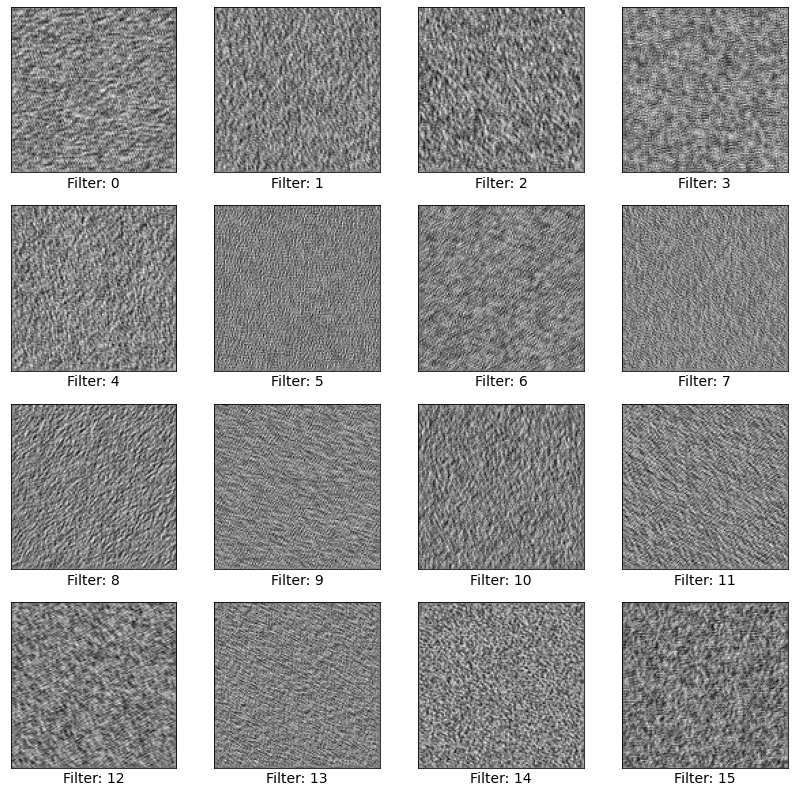

In [51]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [52]:
num_filters = 32
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[5],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

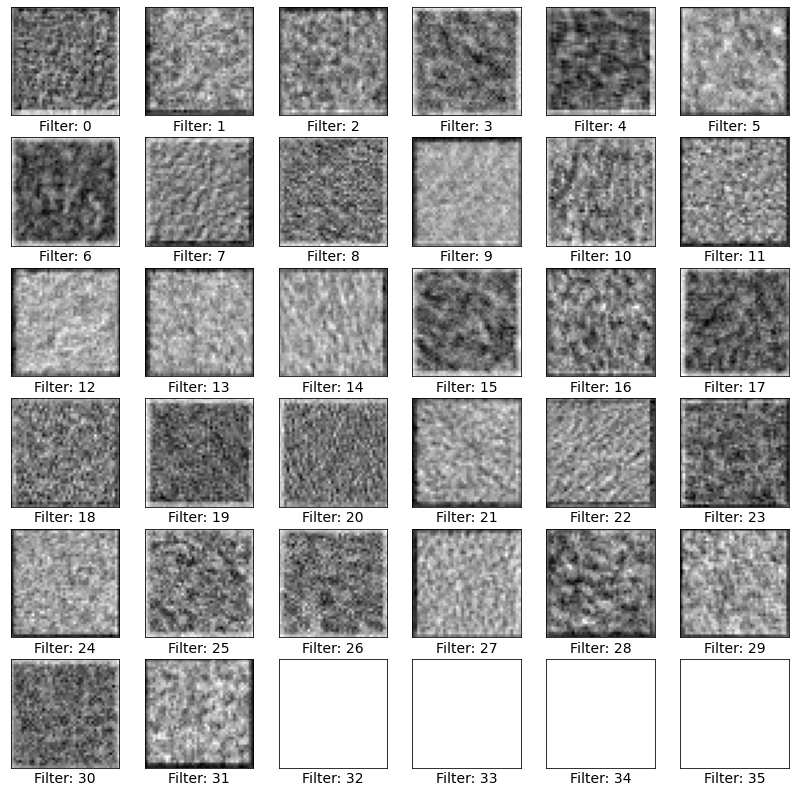

In [53]:
fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [54]:
misclassified, errors = evaluate_func(net, valid, return_misclassified=True)
misclassified[:5], errors[:5]

batches: 100%|██████████| 49/49 [00:00<00:00, 66.21it/s]


(array(['-0.003241758095100522__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev346;1.png',
        '-0.004240238573402166__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev702;1.png',
        '-0.017457688227295876__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev620;1.png',
        '-0.021928340196609497__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev860;1.png',
        '-0.023109635338187218__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev329;1.png'],
       dtype='<U103'), array([2, 2, 2, 2, 2]))

In [55]:
np.bincount(errors, minlength=4), errors.shape

(array([   0,  145, 4356,    8]), (4509,))

In [56]:
misclassified[errors == 3][:10]

array(['-0.42343512177467346__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev696;1.png',
       '0.502601146697998__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev371;1.png',
       '-0.8557000160217285__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev395;1.png',
       '2.2671000957489014__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev399;1.png',
       '02696b64f53acb884066a4fd1e99228c211c1a52.png',
       'dd372fd33712ee0dbbafbd07765a2c21cb62bdb5.png',
       '8b49a27eba9c9d01184ae8ef02230964df814ae5.png',
       'a9f74fd09a2962f33a0acf2e15df22b2f3668129.png'], dtype='<U103')

In [57]:
import pandas as pd


def make_submission(model, iterator, verbose=True):
    model.eval()

    filenames_all = []
    labels_pred_all, values_pred_all = [], []

    if verbose:
        iterator_ = tqdm(iterator, position=0)
    else:
        iterator_ = iterator

    with torch.no_grad():
        for images, *_ in iterator_:
            images = images.to(device)
            labels_pred, values_pred = model(images)

            labels_pred = torch.sigmoid(labels_pred)
            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)
    values_pred = MAPPING_VALUE_INV[values_pred]
    
    submission = pd.DataFrame()
    submission['id'] = iterator.filenames
    submission['classification_predictions'] = labels_pred
    submission['regression_predictions'] = values_pred

    submission['id'] = submission['id'].str.split('.').str[0]
    submission.set_index('id', inplace=True)

    return submission

In [58]:
%%time

dataset_public = IDAODataset.from_path(
    path='idao_dataset/public_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test_new/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15058/15058 [01:23<00:00, 180.55it/s]


CPU times: user 1.98 s, sys: 1.1 s, total: 3.08 s
Wall time: 1min 36s


In [59]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:01<00:00, 68.15it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000065,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000257,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000545,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000145,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.000273,6


In [60]:
submission.shape

(16560, 2)

In [61]:
submission_name = os.path.join(WORK_DIR, 'submission_004-6-3.csv')
submission.to_csv(submission_name, index=True)

In [62]:
dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15062/15062 [01:16<00:00, 197.85it/s]


In [63]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:01<00:00, 68.41it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000065,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000257,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000545,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000145,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.000273,6


In [64]:
submission_name = os.path.join(WORK_DIR, 'submission_004-6-3_old.csv')
submission.to_csv(submission_name, index=True)